In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Ignore future warnings
import warnings

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
from data_loader import load_mouse_fibroblasts

from famo.core import CORE
from famo.plotting import (
    plot_training_curve,
)

warnings.simplefilter(action="ignore", category=FutureWarning)

/data/walter/miniconda3/envs/famo/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
mdata = load_mouse_fibroblasts()
adata = mdata["mrna_allelic"]

In [4]:
model = CORE(device="cuda")
model.fit(
    n_factors=2,
    data={"mrna_allelic": adata},
    likelihoods={"mrna_allelic": "BetaBinomial"},
    factor_prior="Normal",
    weight_prior="ARD_Spike_and_Slab",
    lr=0.005,
    early_stopper_patience=500,
    print_every=100,
    max_epochs=10000,
    save=True,
    save_path=None,
    init_factors="random",
    init_scale=0.1,
    batch_size=10000,
)

Setting up device...
- No device id given. Using default device: 0
- Running all computations on `cuda:0`
Fitting model...
- Checking compatibility of provided likelihoods with data.
  - mrna_allelic: BetaBinomial
- Removing constant features in group_1/mrna_allelic.
  - Removed 56 features: Arl11_c57,BC021614_c57,Calr4_c57,Cfh_c57,Cited1_c57,Cybb_c57,Edaradd_c57,Faah_c57,Fry_c57,G0s2_c57,Il1a_c57,Mertk_c57,Mpzl2_c57,Msln_c57,Myo5b_c57,N28178_c57,Pdzk1ip1_c57,Plp1_c57,Pnma1_c57,Prlr_c57,Rims2_c57,Rph3a_c57,Shisa2_c57,Slc35f2_c57,Spock2_c57,Tigit_c57,Tmem51_c57,Unc5a_c57,Arl11_cast,BC021614_cast,Calr4_cast,Cfh_cast,Cited1_cast,Cybb_cast,Edaradd_cast,Faah_cast,Fry_cast,G0s2_cast,Il1a_cast,Mertk_cast,Mpzl2_cast,Msln_cast,Myo5b_cast,N28178_cast,Pdzk1ip1_cast,Plp1_cast,Pnma1_cast,Prlr_cast,Rims2_cast,Rph3a_cast,Shisa2_cast,Slc35f2_cast,Spock2_cast,Tigit_cast,Tmem51_cast,Unc5a_cast
Initializing factors using `random` method...
Epoch:       0 | Time:       1.08s | Loss: 2018299.68
Epoch:     

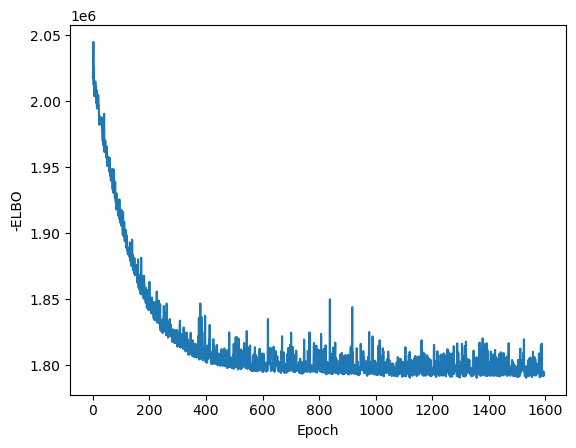

In [5]:
plot_training_curve(model)

In [6]:
factors = model.get_factors()
weights = model.get_weights()

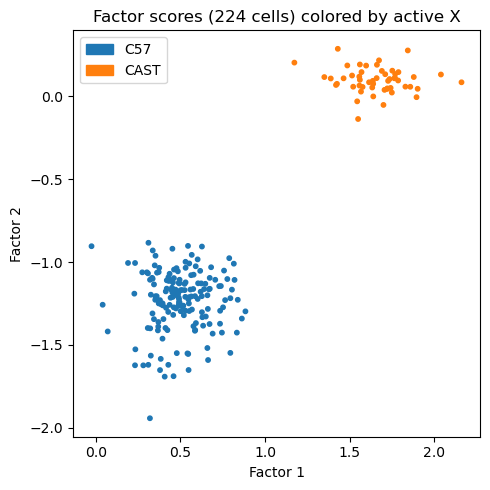

In [7]:
color = ["C0" if x == "c57" else "C1" if x == "cast" else "C3" for x in mdata["mrna_allelic"].obs["active_X"]]

fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(factors["group_1"][0], factors["group_1"][1], s=10, c=color)
ax.set_title("Factor scores (224 cells) colored by active X")
ax.set_xlabel("Factor 1")
ax.set_ylabel("Factor 2")
legend_elements = [mpatches.Patch(color="C0", label="C57"), mpatches.Patch(color="C1", label="CAST")]
ax.legend(handles=legend_elements, loc="upper left")
plt.tight_layout()
plt.show()

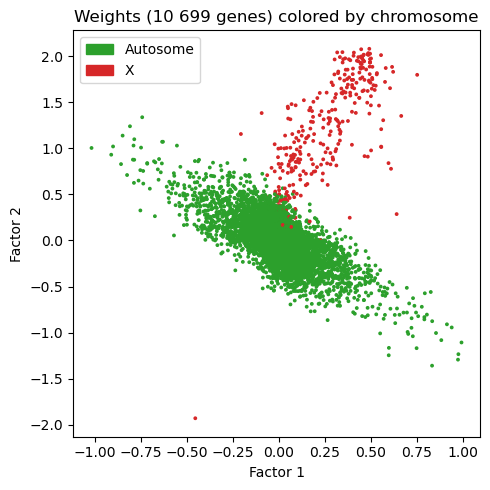

In [8]:
genes = pd.DataFrame({"gene": model.feature_names["mrna_allelic"]})
chroms = pd.merge(genes, mdata["mrna_allelic"].var, left_on="gene", right_on="gene", how="inner")[::2].chrom

color = ["C2" if not x else "C3" for x in chroms == "chrX"]

fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(weights["mrna_allelic"][0], weights["mrna_allelic"][1], s=3, c=color)
ax.set_title("Weights (10 699 genes) colored by chromosome")
ax.set_xlabel("Factor 1")
ax.set_ylabel("Factor 2")
legend_elements = [mpatches.Patch(color="C2", label="Autosome"), mpatches.Patch(color="C3", label="X")]
ax.legend(handles=legend_elements, loc="upper left")
plt.tight_layout()
plt.show()